# 合并 EDA Notebook — edanotebook

此笔记本由 `EDA.ipynb` 与 `eda(2).ipynb` 合并生成：保留原有分析结构、去除重复导入/重复步骤，并将两个笔记本互相补充的分析整合在一起。

- 主要内容：数据加载、清洗、球员计数、赛制推断、逐场/逐点时序特征提取、各类可视化（分布、时序、局/盘注释）、以及若干 player-level 与 run-level 分析。

- 输出文件（示例）：`player_counts.csv`, `match_inferred_format.csv`, `playerpair_inferred_format.csv`, `match_time_series_features.csv` 等。

In [52]:
# Consolidated imports and data loading (合并并兼容两份笔记本的读取逻辑)
import os
from pathlib import Path
import re
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# DATA_DIR: 优先使用当前 notebook 所在目录的 2024C 文件夹（若在 VS Code 中运行），否则回退到相对路径
NB_DIR = os.path.dirname(os.path.abspath("edanotebook.ipynb")) if os.path.exists('edanotebook.ipynb') else '.'
DATA_DIR = os.path.join(NB_DIR, '2024C') if os.path.basename(NB_DIR).lower() != '2024c' and os.path.exists(os.path.join(NB_DIR, '2024C')) else NB_DIR
# 如果 DATA_DIR 不存在则回退为 notebook 目录本身
if not os.path.exists(DATA_DIR):
    DATA_DIR = NB_DIR

# 常用路径
matches_fp = os.path.join(DATA_DIR, '2024_Wimbledon_featured_matches.csv')
dict_fp = os.path.join(DATA_DIR, '2024_data_dictionary.csv')
fixed_fp = os.path.join(DATA_DIR, 'match_time_series_features_fixed.csv')
features_out_fp = os.path.join(DATA_DIR, 'match_time_series_features.csv')
player_counts_fp = os.path.join(DATA_DIR, 'player_counts.csv')

# 读取（容错）
def safe_read_csv(p):
    try:
        return pd.read_csv(p)
    except Exception as e:
        print('Warning: failed to read', p, '->', e)
        return pd.DataFrame()

print('DATA_DIR =', DATA_DIR)
df = safe_read_csv(matches_fp)
data_dict = safe_read_csv(dict_fp)

# 基础清洗与衍生列：elapsed_time -> elapsed_sec; server_win; 排序保证点序列正确
def elapsed_to_seconds(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if ':' in s:
        parts = s.split(':')
        try:
            if len(parts) == 3:
                h, m, sec = parts
                return int(h)*3600 + int(m)*60 + float(sec)
            if len(parts) == 2:
                m, sec = parts
                return int(m)*60 + float(sec)
        except Exception:
            try: return float(s)
            except: return np.nan
    # patterns like 1h2m3s / 90s
    m = re.match(r'^(?:(?P<h>\d+)h)?(?:(?P<m>\d+)m)?(?:(?P<s>\d+(?:\.\d+)?)s)?$', s)
    if m:
        h = float(m.group('h')) if m.group('h') else 0.0
        mm = float(m.group('m')) if m.group('m') else 0.0
        ss = float(m.group('s')) if m.group('s') else 0.0
        return int(h*3600 + mm*60 + ss)
    try:
        return float(s)
    except:
        return np.nan

if not df.empty:
    if 'elapsed_time' in df.columns:
        df['elapsed_seconds'] = df['elapsed_time'].apply(elapsed_to_seconds)
    # server_win 估算（若存在相应列）
    if all(c in df.columns for c in ['point_victor','server']):
        df['server_win'] = np.where((df['point_victor'] == df['server']), 1, np.where(df['point_victor'].isin([1,2]) & df['server'].isin([1,2]), 0, np.nan))
    # 排序保证顺序一致性
    sort_cols = [c for c in ['match_id','set_no','game_no','point_no'] if c in df.columns]
    if sort_cols:
        df = df.sort_values(sort_cols).reset_index(drop=True)

print('Loaded df shape:', df.shape)
print('Loaded data_dict shape:', getattr(data_dict, 'shape', None))

DATA_DIR = e:\Documents\Mathematical-Modelling\2024C
Loaded df shape: (7284, 48)
Loaded data_dict shape: (46, 3)


# 数据统计：球员出现次数与赛制推断

本笔记本包含：
1. 加载 `2024_Wimbledon_featured_matches.csv` 和 `2024_data_dictionary.csv`。
2. 统计每位球员在数据中出现的次数（作为 `player1` 或 `player2`）。
3. 可视化前20名常出现球员。
4. 根据每场比赛的 `set_no` 与选手获胜的最大盘数推断赛制（如 best-of-3 / best-of-5）。
5. 导出 `player_counts.csv` 与 `inferred_format.txt` 供后续建模使用。

前20名球员出现次数：
                         player  appearances
0                Carlos Alcaraz         1207
1                Novak Djokovic         1191
2                 Andrey Rublev          838
3                 Jannik Sinner          823
4               Daniil Medvedev          810
5           Christopher Eubanks          801
6                   Holger Rune          800
7               Roman Safiullin          558
8            Daniel Elahi Galan          533
9              Alexander Bublik          516
10           Stefanos Tsitsipas          476
11             Denis Shapovalov          470
12               Hubert Hurkacz          469
13                 Jiri Lehecka          454
14            Matteo Berrettini          426
15              Grigor Dimitrov          408
16  Alejandro Davidovich Fokina          337
17                   Tommy Paul          332
18                  Mikael Ymer          318
19                Nicolas Jarry          300


C:\Users\DELL\AppData\Local\Temp\ipykernel_102676\2160816404.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top20, y='player', x='appearances', palette='viridis')


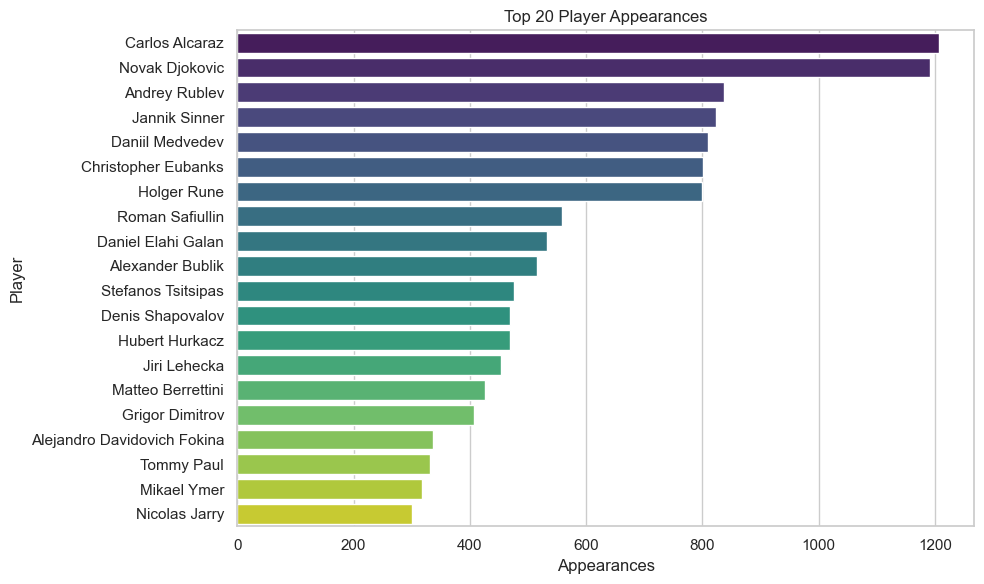

已导出球员出现次数至： e:\Documents\Mathematical-Modelling\2024C\player_counts.csv


In [53]:
# 统计球员出现次数并可视化前20名
if df.empty:
    print('df 为空，无法统计球员出现次数，请检查数据路径或先运行数据加载单元。')
else:
    players = pd.concat([df['player1'], df['player2']], axis=0).reset_index(drop=True)
    player_counts = players.value_counts().rename_axis('player').reset_index(name='appearances')
    player_counts = player_counts.sort_values('appearances', ascending=False).reset_index(drop=True)

    # 显示前20名
    top20 = player_counts.head(20)
    print('前20名球员出现次数：')
    print(top20)

    # 绘图
    plt.figure(figsize=(10,6))
    sns.barplot(data=top20, y='player', x='appearances', palette='viridis')
    plt.title('Top 20 Player Appearances')
    plt.xlabel('Appearances')
    plt.ylabel('Player')
    plt.tight_layout()
    plt.show()

    # 导出球员计数供后续分析使用
    out_fp = player_counts_fp
    player_counts.to_csv(out_fp, index=False)
    print('已导出球员出现次数至：', out_fp)

In [54]:
# 按比赛与球员对推断赛制并导出结果
if df.empty:
    print('df 为空，跳过赛制推断。')
else:
    match_max_set = df.groupby('match_id')['set_no'].max().rename('max_set_no')
    match_winner_sets = df.groupby('match_id').agg({'p1_sets':'max','p2_sets':'max'})
    match_winner_sets['winner_max_sets'] = match_winner_sets[['p1_sets','p2_sets']].max(axis=1)
    match_info = df.groupby('match_id').agg({'player1':'first','player2':'first'}).join(match_max_set).join(match_winner_sets['winner_max_sets']).reset_index()

    def infer_format(row):
        if pd.isna(row['winner_max_sets']) and pd.isna(row['max_set_no']):
            return 'unknown'
        if not pd.isna(row['winner_max_sets']):
            if row['winner_max_sets'] >= 3:
                return 'best-of-5'
            if row['winner_max_sets'] == 2:
                return 'best-of-3'
        if not pd.isna(row['max_set_no']):
            if int(row['max_set_no']) >= 5:
                return 'best-of-5 (observed set_no>=5)'
            if int(row['max_set_no']) <= 3:
                return 'best-of-3 (observed set_no<=3)'
        return 'unknown'

    match_info['inferred_format'] = match_info.apply(infer_format, axis=1)

    def check_inconsistency(row):
        notes = []
        if (not pd.isna(row['max_set_no'])) and (int(row['max_set_no']) >=5) and (pd.isna(row['winner_max_sets']) or row['winner_max_sets'] < 3):
            notes.append('observed set_no>=5 but no winner reached 3 sets')
        return '; '.join(notes) if notes else ''

    match_info['notes'] = match_info.apply(check_inconsistency, axis=1)
    match_info['pair'] = match_info.apply(lambda r: ' vs '.join(sorted([r['player1'], r['player2']])), axis=1)
    pair_summary = match_info.groupby('pair')['inferred_format'].value_counts().unstack(fill_value=0)

    def dominant_format(row):
        if row.sum() == 0:
            return 'unknown'
        maxv = row.max()
        dom = row[row==maxv].index.tolist()
        return ','.join(dom)

    pair_summary['dominant_format'] = pair_summary.apply(dominant_format, axis=1)
    pair_summary = pair_summary.reset_index()

    out_matches = os.path.join(DATA_DIR, 'match_inferred_format.csv')
    out_pairs = os.path.join(DATA_DIR, 'playerpair_inferred_format.csv')
    match_info.to_csv(out_matches, index=False)
    pair_summary.to_csv(out_pairs, index=False)
    print('已导出每场赛制推断：', out_matches)
    print('已导出每对球员的赛制汇总：', out_pairs)
    print('示例 match_info（前10行）：')
    print(match_info.head(10))
    print('存在潜在不一致的比赛：')
    print(match_info[match_info['notes']!=''][['match_id','player1','player2','max_set_no','winner_max_sets','inferred_format','notes']].head(20))

已导出每场赛制推断： e:\Documents\Mathematical-Modelling\2024C\match_inferred_format.csv
已导出每对球员的赛制汇总： e:\Documents\Mathematical-Modelling\2024C\playerpair_inferred_format.csv
示例 match_info（前10行）：
              match_id                      player1                player2  \
0  2023-wimbledon-1301               Carlos Alcaraz          Nicolas Jarry   
1  2023-wimbledon-1302             Alexander Zverev      Matteo Berrettini   
2  2023-wimbledon-1303               Frances Tiafoe        Grigor Dimitrov   
3  2023-wimbledon-1304  Alejandro Davidovich Fokina            Holger Rune   
4  2023-wimbledon-1305              Daniil Medvedev       Marton Fucsovics   
5  2023-wimbledon-1306                 Jiri Lehecka             Tommy Paul   
6  2023-wimbledon-1307          Christopher Eubanks  Christopher O'Connell   
7  2023-wimbledon-1308                  Laslo Djere     Stefanos Tsitsipas   
8  2023-wimbledon-1309                Jannik Sinner          Quentin Halys   
9  2023-wimbledon-1310           

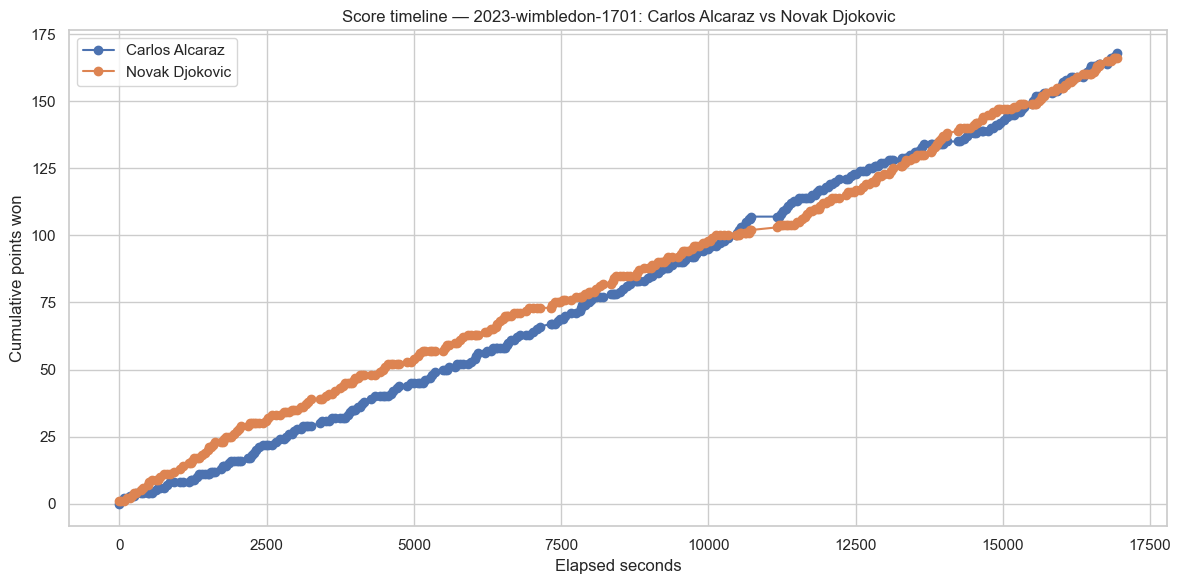

已保存图像至： e:\Documents\Mathematical-Modelling\2024C\last_match_2023-wimbledon-1701_score_timeseries.png
最后一场比赛: 2023-wimbledon-1701
球员: Carlos Alcaraz vs Novak Djokovic
最终累计得分 (p1_points_won, p2_points_won): 168 166


In [55]:
# 绘制最后一场比赛的双方分数时序对比图（如数据存在）
if df.empty:
    print('df 为空，跳过最后一场比赛绘图。')
else:
    last_match_id = df['match_id'].iloc[-1]
    df_last = df[df['match_id'] == last_match_id].copy()

    def time_to_seconds(t):
        try:
            parts = str(t).split(':')
            if len(parts) == 3:
                h, m, s = map(int, parts)
                return h*3600 + m*60 + s
        except:
            return np.nan
        return np.nan

    df_last['elapsed_seconds'] = df_last['elapsed_time'].apply(time_to_seconds) if 'elapsed_time' in df_last.columns else np.nan
    df_last = df_last.reset_index(drop=True)
    df_last['point_index'] = np.arange(1, len(df_last) + 1)
    x_col = 'elapsed_seconds' if df_last['elapsed_seconds'].notna().any() else 'point_index'
    x_label = 'Elapsed seconds' if x_col == 'elapsed_seconds' else 'Point index'

    if len(df_last) == 0:
        print('没有可用的最后一场比赛数据，跳过绘图。')
    else:
        player1_name = df_last['player1'].iat[0] if 'player1' in df_last.columns and len(df_last) > 0 else 'player1'
        player2_name = df_last['player2'].iat[0] if 'player2' in df_last.columns and len(df_last) > 0 else 'player2'

        plt.figure(figsize=(12,6))
        plt.plot(df_last[x_col], df_last['p1_points_won'], marker='o', label=player1_name)
        plt.plot(df_last[x_col], df_last['p2_points_won'], marker='o', label=player2_name)
        plt.xlabel(x_label)
        plt.ylabel('Cumulative points won')
        plt.title(f'Score timeline — {last_match_id}: {player1_name} vs {player2_name}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        out_plot = os.path.join(DATA_DIR, f'last_match_{last_match_id}_score_timeseries.png')
        plt.savefig(out_plot, dpi=150)
        plt.show()
        print('已保存图像至：', out_plot)

        final_p1 = df_last['p1_points_won'].iat[-1] if len(df_last)>0 else None
        final_p2 = df_last['p2_points_won'].iat[-1] if len(df_last)>0 else None
        print('最后一场比赛:', last_match_id)
        print('球员:', player1_name, 'vs', player2_name)
        print('最终累计得分 (p1_points_won, p2_points_won):', final_p1, final_p2)

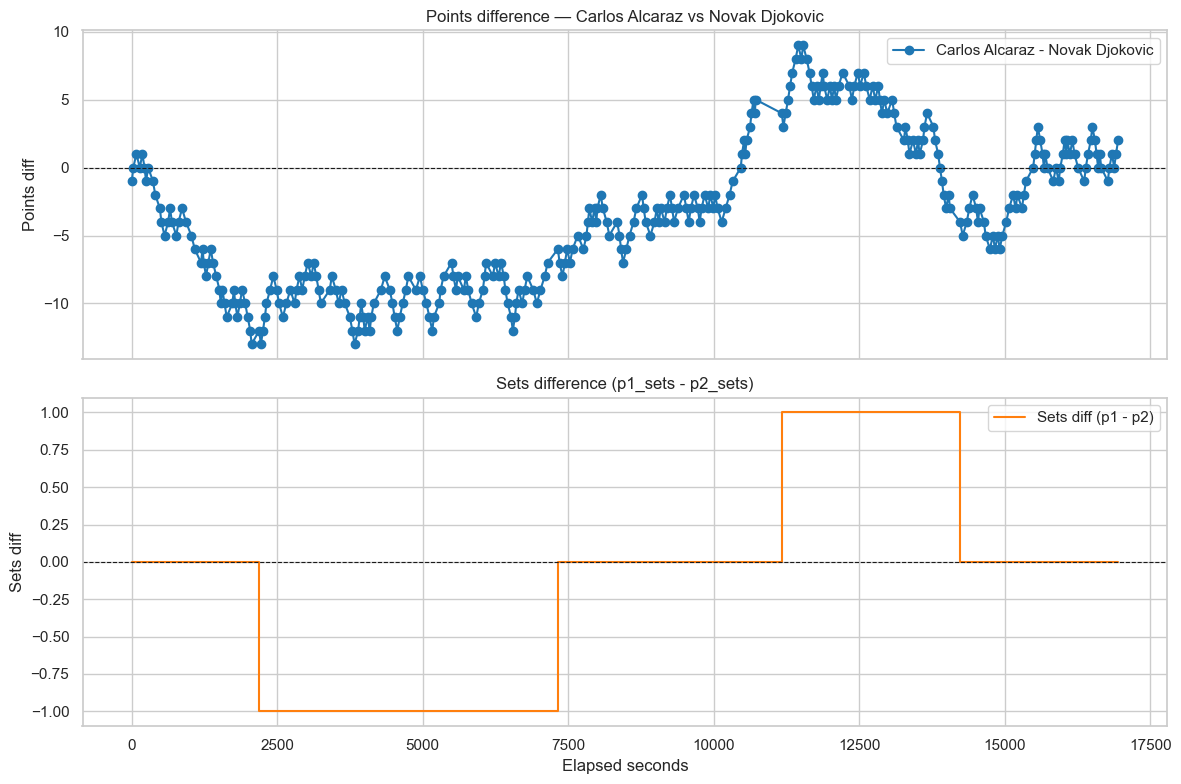

已保存差值图至： e:\Documents\Mathematical-Modelling\2024C\last_match_2023-wimbledon-1701_diffs.png


In [56]:
# 上下子图展示累计分差与盘差（如数据存在）
if df.empty:
    print('df 为空，跳过差值绘图。')
else:
    last_match_id = df['match_id'].iloc[-1]
    df_last = df[df['match_id'] == last_match_id].copy().reset_index(drop=True)

    def time_to_seconds(t):
        try:
            parts = str(t).split(':')
            if len(parts) == 3:
                h, m, s = map(int, parts)
                return h*3600 + m*60 + s
        except:
            return np.nan
        return np.nan

    if df_last.shape[0] == 0:
        print('没有可用的最后一场比赛数据，跳过差值绘图。')
    else:
        df_last['elapsed_seconds'] = df_last['elapsed_time'].apply(time_to_seconds) if 'elapsed_time' in df_last.columns else np.nan
        df_last['point_index'] = np.arange(1, len(df_last) + 1)
        x_col = 'elapsed_seconds' if df_last['elapsed_seconds'].notna().any() else 'point_index'
        x_label = 'Elapsed seconds' if x_col == 'elapsed_seconds' else 'Point index'

        player1_name = df_last['player1'].iat[0] if 'player1' in df_last.columns and len(df_last) > 0 else 'player1'
        player2_name = df_last['player2'].iat[0] if 'player2' in df_last.columns and len(df_last) > 0 else 'player2'

        if 'p1_points_won' in df_last.columns and 'p2_points_won' in df_last.columns:
            points_diff = df_last['p1_points_won'] - df_last['p2_points_won']
        else:
            points_diff = None

        if 'p1_sets' in df_last.columns and 'p2_sets' in df_last.columns:
            sets_diff = df_last['p1_sets'] - df_last['p2_sets']
        else:
            sets_diff = None

        fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        if points_diff is not None:
            axes[0].plot(df_last[x_col], points_diff, marker='o', color='tab:blue', label=f'{player1_name} - {player2_name}')
            axes[0].axhline(0, color='k', linestyle='--', linewidth=0.8)
            axes[0].set_ylabel('Points diff')
            axes[0].set_title(f'Points difference — {player1_name} vs {player2_name}')
            axes[0].legend()
        else:
            axes[0].text(0.5, 0.5, '缺少 p1_points_won 或 p2_points_won 列，无法绘制分差', ha='center', va='center')
            axes[0].set_title('Points difference (data missing)')

        if sets_diff is not None:
            axes[1].step(df_last[x_col], sets_diff, where='post', color='tab:orange', label='Sets diff (p1 - p2)')
            axes[1].axhline(0, color='k', linestyle='--', linewidth=0.8)
            axes[1].set_ylabel('Sets diff')
            axes[1].set_title('Sets difference (p1_sets - p2_sets)')
            axes[1].legend()
        else:
            if points_diff is not None:
                axes[1].plot(df_last[x_col], points_diff, marker='o', color='tab:green', label='Points diff (backup)')
                axes[1].set_ylabel('Points diff (backup)')
                axes[1].set_title('Sets difference not available — showing points diff')
                axes[1].legend()
            else:
                axes[1].text(0.5, 0.5, '缺少用于绘图的列', ha='center', va='center')
                axes[1].set_title('No data available')

        axes[1].set_xlabel(x_label)
        for ax in axes:
            ax.grid(True)

        plt.tight_layout()
        out_plot = os.path.join(DATA_DIR, f'last_match_{last_match_id}_diffs.png')
        plt.savefig(out_plot, dpi=150)
        plt.show()
        print('已保存差值图至：', out_plot)

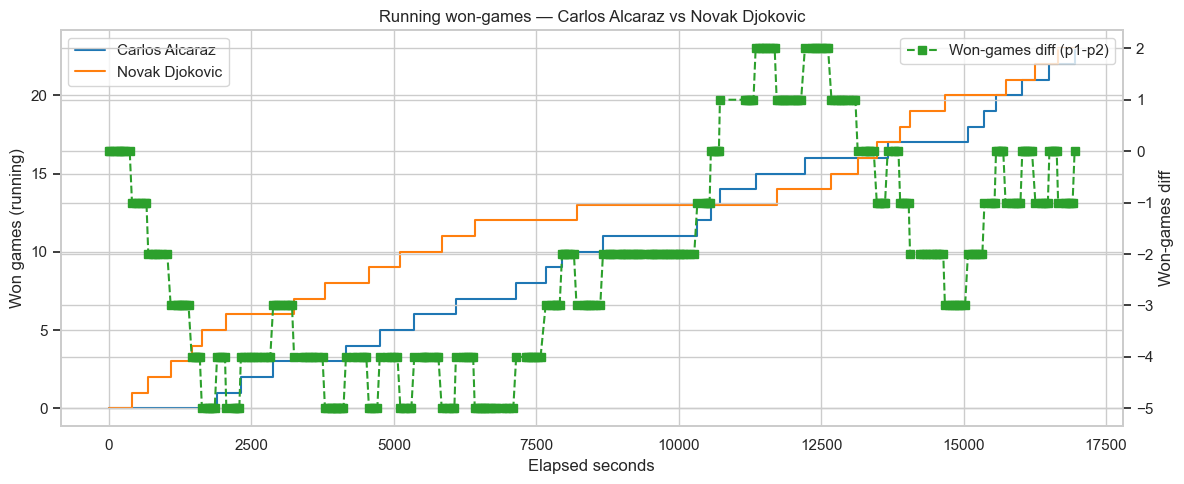

已保存按已赢局累积的图至： e:\Documents\Mathematical-Modelling\2024C\last_match_2023-wimbledon-1701_won_games_running.png


In [57]:
# Games 对比 — 按实际赢局累积的局数差（使用 game_victor 或 回退方法）
if df.empty:
    print('df 为空，跳过按赢局累积的 games 绘图。')
else:
    last_match_id = df['match_id'].iloc[-1]
    df_last = df[df['match_id'] == last_match_id].copy().reset_index(drop=True)

    def time_to_seconds(t):
        try:
            parts = str(t).split(':')
            if len(parts) == 3:
                h, m, s = map(int, parts)
                return h*3600 + m*60 + s
        except:
            return np.nan
        return np.nan

    if df_last.shape[0] == 0:
        print('没有可用的最后一场比赛数据，跳过按赢局累积的 games 绘图。')
    else:
        df_last['elapsed_seconds'] = df_last['elapsed_time'].apply(time_to_seconds) if 'elapsed_time' in df_last.columns else np.nan
        df_last['point_index'] = np.arange(1, len(df_last) + 1)
        x_col = 'elapsed_seconds' if df_last['elapsed_seconds'].notna().any() else 'point_index'
        x_label = 'Elapsed seconds' if x_col == 'elapsed_seconds' else 'Point index'

        player1_name = df_last['player1'].iat[0] if 'player1' in df_last.columns and len(df_last) > 0 else 'player1'
        player2_name = df_last['player2'].iat[0] if 'player2' in df_last.columns and len(df_last) > 0 else 'player2'

        running_p1 = []
        running_p2 = []
        p1_count = 0
        p2_count = 0

        if 'game_victor' in df_last.columns:
            for _, row in df_last.sort_values(['set_no','game_no','point_no']).iterrows():
                gv = row['game_victor']
                try:
                    if pd.notna(gv):
                        igv = int(gv)
                        if igv == 1:
                            p1_count += 1
                        elif igv == 2:
                            p2_count += 1
                except Exception:
                    s = str(gv).lower()
                    if 'p1' in s or player1_name.lower() in s:
                        p1_count += 1
                    elif 'p2' in s or player2_name.lower() in s:
                        p2_count += 1
                running_p1.append(p1_count)
                running_p2.append(p2_count)
        else:
            prev_game = None
            for _, row in df_last.sort_values(['set_no','game_no','point_no']).iterrows():
                curr_game = (int(row['set_no']), int(row['game_no'])) if 'set_no' in row and 'game_no' in row else None
                if prev_game is None:
                    pass
                prev_game = curr_game
                if 'p1_games' in df_last.columns and 'p2_games' in df_last.columns:
                    running_p1.append(int(row['p1_games']))
                    running_p2.append(int(row['p2_games']))
                else:
                    running_p1.append(0)
                    running_p2.append(0)

        df_last = df_last.sort_values(['set_no','game_no','point_no']).reset_index(drop=True)
        df_last['running_games_p1'] = running_p1
        df_last['running_games_p2'] = running_p2
        df_last['running_games_diff'] = df_last['running_games_p1'] - df_last['running_games_p2']

        fig, ax1 = plt.subplots(figsize=(12,5))
        ax1.step(df_last[x_col], df_last['running_games_p1'], where='post', label=player1_name, color='tab:blue')
        ax1.step(df_last[x_col], df_last['running_games_p2'], where='post', label=player2_name, color='tab:orange')
        ax1.set_xlabel(x_label)
        ax1.set_ylabel('Won games (running)')
        ax1.set_title(f'Running won-games — {player1_name} vs {player2_name}')
        ax1.legend(loc='upper left')
        ax1.grid(True)

        ax2 = ax1.twinx()
        ax2.plot(df_last[x_col], df_last['running_games_diff'], marker='s', linestyle='--', color='tab:green', label='Won-games diff (p1-p2)')
        ax2.set_ylabel('Won-games diff')
        ax2.legend(loc='upper right')

        plt.tight_layout()
        out_plot = os.path.join(DATA_DIR, f'last_match_{last_match_id}_won_games_running.png')
        plt.savefig(out_plot, dpi=150)
        plt.show()
        print('已保存按已赢局累积的图至：', out_plot)

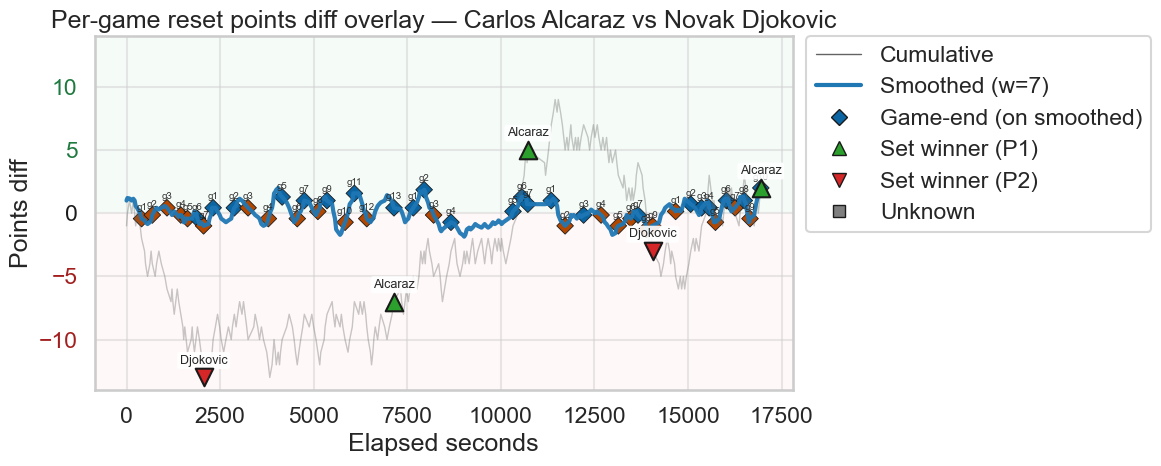

已保存每局结束 points overlay： e:\Documents\Mathematical-Modelling\2024C\last_match_2023-wimbledon-1701_game_end_points_overlay.png


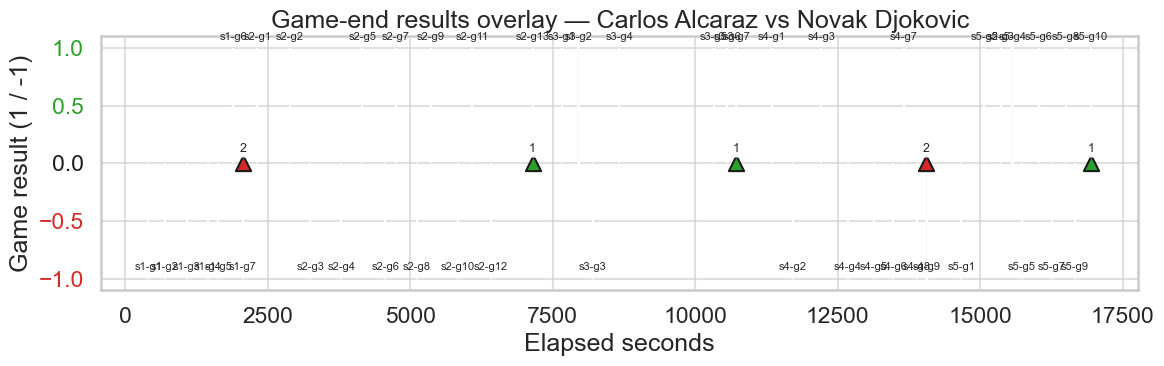

已保存每局结束 games overlay： e:\Documents\Mathematical-Modelling\2024C\last_match_2023-wimbledon-1701_game_end_games_overlay.png
每局结束的差值（局内，从零开始）：


,set_no,game_no,p1_points_in_game,p2_points_in_game,points_diff_in_game,games_diff_in_game,game_winner_name
0,1,1,4,5,-1,-1,Novak Djokovic
1,1,2,2,3,-1,-1,Novak Djokovic
2,1,3,2,3,-1,-1,Novak Djokovic
3,1,4,3,4,-1,-1,Novak Djokovic
4,1,5,1,3,-2,-1,Novak Djokovic
5,1,6,3,2,1,1,Carlos Alcaraz
6,1,7,0,3,-3,-1,Novak Djokovic
7,2,1,3,1,2,1,Carlos Alcaraz
8,2,2,5,4,1,1,Carlos Alcaraz
9,2,3,3,4,-1,-1,Novak Djokovic


In [58]:
# Cell X: 在原图上标注每局结束时的 points 与 games 差（每局从零重新计算，不覆盖原图），并在每个 set 结束处标注胜者（优先使用真实数据字段）
last_match_id = df['match_id'].iloc[-1]
df_last = df[df['match_id'] == last_match_id].copy().reset_index(drop=True)

# 准备 x 轴
def time_to_seconds(t):
    try:
        parts = str(t).split(':')
        if len(parts) == 3:
            h, m, s = map(int, parts)
            return h*3600 + m*60 + s
    except:
        return np.nan
    return np.nan

if df_last.shape[0] == 0:
    print('没有可用的最后一场比赛数据，跳过每局结束标注。')
else:
    import seaborn as sns
    sns.set_style('whitegrid')
    sns.set_context('talk')

    # 保证按 set/game/point 排序
    df_last = df_last.sort_values(['set_no','game_no','point_no']).reset_index(drop=True)
    df_last['elapsed_seconds'] = df_last['elapsed_time'].apply(time_to_seconds) if 'elapsed_time' in df_last.columns else np.nan
    df_last['point_index'] = np.arange(1, len(df_last) + 1)
    x_col = 'elapsed_seconds' if df_last['elapsed_seconds'].notna().any() else 'point_index'
    x_label = 'Elapsed seconds' if x_col == 'elapsed_seconds' else 'Point index'

    player1_name = df_last['player1'].iat[0] if 'player1' in df_last.columns and len(df_last)>0 else 'p1'
    player2_name = df_last['player2'].iat[0] if 'player2' in df_last.columns and len(df_last)>0 else 'p2'

    # 计算每局（game）开始与结束的行，并在每局内部从零重新计算点数差
    grp = df_last.groupby(['set_no','game_no'], sort=True)
    game_starts = grp.first().reset_index()[['set_no','game_no','p1_points_won','p2_points_won']].rename(columns={'p1_points_won':'p1_points_start','p2_points_won':'p2_points_start'})
    end_cols = ['set_no','game_no','p1_points_won','p2_points_won','game_victor']
    if x_col in df_last.columns:
        end_cols.append(x_col)
    game_ends = grp.last().reset_index()[end_cols].rename(columns={'p1_points_won':'p1_points_end','p2_points_won':'p2_points_end', x_col: x_col} if x_col in df_last.columns else {'p1_points_won':'p1_points_end','p2_points_won':'p2_points_end'})

    # 将每局起始分合并回原表以计算局内累计得分（从0开始）
    df_last['p1_points_game_start'] = grp['p1_points_won'].transform('first')
    df_last['p2_points_game_start'] = grp['p2_points_won'].transform('first')
    df_last['p1_points_in_game'] = df_last['p1_points_won'] - df_last['p1_points_game_start']
    df_last['p2_points_in_game'] = df_last['p2_points_won'] - df_last['p2_points_game_start']
    df_last['points_diff_in_game'] = df_last['p1_points_in_game'] - df_last['p2_points_in_game']
    df_last['point_in_game_idx'] = grp.cumcount()

    # 计算每局结束时的局内差值与局胜者（若 game_victor 可用优先使用），并将其加入 game_ends
    game_ends = game_ends.merge(game_starts, on=['set_no','game_no'], how='left')
    game_ends['p1_points_in_game'] = game_ends['p1_points_end'] - game_ends['p1_points_start']
    game_ends['p2_points_in_game'] = game_ends['p2_points_end'] - game_ends['p2_points_start']
    game_ends['points_diff_in_game'] = game_ends['p1_points_in_game'] - game_ends['p2_points_in_game']

    # 映射 game_victor 到真实球员名（优先使用明确字段），并保留数值列用于绘图
    def map_game_victor_to_name(row):
        gv = row.get('game_victor') if hasattr(row, 'get') else None
        try:
            if pd.notna(gv):
                igv = int(gv)
                if igv == 1:
                    return player1_name
                if igv == 2:
                    return player2_name
        except Exception:
            s = str(gv).lower() if gv is not None else ''
            if player1_name.lower() in s or 'p1' in s:
                return player1_name
            if player2_name.lower() in s or 'p2' in s:
                return player2_name
        # fallback: 使用局内得分判定
        try:
            if row['p1_points_in_game'] > row['p2_points_in_game']:
                return player1_name
            if row['p1_points_in_game'] < row['p2_points_in_game']:
                return player2_name
        except Exception:
            pass
        return None

    game_ends['game_winner_name'] = game_ends.apply(map_game_victor_to_name, axis=1)
    # 兼容老逻辑：保留 +1/-1 标志列
    def game_winner_sign(name):
        if pd.isna(name) or name is None:
            return 0
        return 1 if name == player1_name else (-1 if name == player2_name else 0)
    game_ends['games_diff_in_game'] = game_ends['game_winner_name'].apply(game_winner_sign)

    # 计算每盘结束的行并判定盘胜者，用于在图上标注
    set_ends = df_last.groupby('set_no', sort=True).last().reset_index()

    # 不再依赖累计 points 直接判定；优先使用真实字段：
    # 1) 如果存在明确的 set-winner 字段（如 set_winner / set_victor / set_winner_name），直接映射为球员名；
    # 2) 否则如果行中有 p1_sets/p2_sets 列，则比较它们在该盘末行的值来判定（这是数据源记录的累计盘数，通常可靠）；
    # 3) 否则尝试基于每局的 game_victor 聚合判断；
    # 4) 最后回退为基于已推断的每局胜者累加（games_diff_in_game 总和）。

    # helper: 尝试映射任意候选列到球员名
    def map_field_to_player(val):
        if pd.isna(val):
            return 'unknown'
        try:
            iv = int(val)
            if iv == 1:
                return player1_name
            if iv == 2:
                return player2_name
        except Exception:
            s = str(val).lower()
            if player1_name.lower() in s or 'p1' in s:
                return player1_name
            if player2_name.lower() in s or 'p2' in s:
                return player2_name
        return str(val)

    # 1) 查找明确的 set-winner 列
    set_winner_col = None
    for cand in ['set_winner','set_victor','set_winner_name','set_winner_id']:
        if cand in set_ends.columns:
            set_winner_col = cand
            break
    if set_winner_col is not None:
        set_ends['set_winner'] = set_ends[set_winner_col].apply(map_field_to_player)
    elif 'p1_sets' in set_ends.columns and 'p2_sets' in set_ends.columns:
        set_ends['set_winner'] = np.where(set_ends['p1_sets'] > set_ends['p2_sets'], player1_name,
                                           np.where(set_ends['p2_sets'] > set_ends['p1_sets'], player2_name, 'unknown'))
    else:
        # 尝试基于 game_victor 字段聚合
        if 'game_victor' in game_ends.columns:
            tmp = game_ends.copy()
            def gv_val(gv):
                try:
                    if pd.isna(gv):
                        return 0
                    ig = int(gv)
                    return 1 if ig == 1 else (-1 if ig == 2 else 0)
                except Exception:
                    s = str(gv).lower()
                    if player1_name.lower() in s or 'p1' in s: return 1
                    if player2_name.lower() in s or 'p2' in s: return -1
                    return 0
            tmp['gv_val'] = tmp['game_victor'].apply(gv_val)
            gv_sum = tmp.groupby('set_no')['gv_val'].sum().reset_index()
            gv_sum['set_winner'] = np.where(gv_sum['gv_val'] > 0, player1_name, np.where(gv_sum['gv_val'] < 0, player2_name, 'unknown'))
            set_ends = set_ends.merge(gv_sum[['set_no','set_winner']], on='set_no', how='left')
            # 对仍为 unknown 的，再尝试使用已推断的每局胜者累加
            unknown_sets = set_ends['set_winner'].isna() | (set_ends['set_winner']=='unknown')
            if unknown_sets.any():
                tmp2 = game_ends.groupby('set_no')['games_diff_in_game'].sum().reset_index()
                tmp2['set_winner'] = np.where(tmp2['games_diff_in_game'] > 0, player1_name, np.where(tmp2['games_diff_in_game'] < 0, player2_name, 'unknown'))
                set_ends = set_ends.drop(columns=['set_winner']).merge(tmp2[['set_no','set_winner']], on='set_no', how='left')
        else:
            tmp2 = game_ends.groupby('set_no')['games_diff_in_game'].sum().reset_index()
            tmp2['set_winner'] = np.where(tmp2['games_diff_in_game'] > 0, player1_name, np.where(tmp2['games_diff_in_game'] < 0, player2_name, 'unknown'))
            set_ends = set_ends.merge(tmp2[['set_no','set_winner']], on='set_no', how='left')

    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    # Points diff (timeline original) + per-game reset overlay（增强版）
    if 'p1_points_won' in df_last.columns and 'p2_points_won' in df_last.columns:
        plt.figure(figsize=(12,5))
        pts_diff_total = df_last['p1_points_won'] - df_last['p2_points_won']
        # 修改累计线配色
        plt.plot(df_last[x_col], pts_diff_total, marker=None, linewidth=1, alpha=0.35, label='Points diff (cumulative)', color='#636363')

        # 平滑参数（可调整）
        smooth_window = 7
        raw = df_last['points_diff_in_game']
        smooth = raw.rolling(window=smooth_window, center=True, min_periods=1).mean()
        # 仅保留平滑曲线，增强对比（更粗、更深的颜色）
        plt.plot(df_last[x_col], smooth, linewidth=3.0, alpha=0.95, color='#1f77b4', label=f'Points diff (smoothed, w={smooth_window})')

        # game-end 标记按胜者着色（使用真实名字判断），并放置在 smoothed 曲线上
        if x_col in game_ends.columns:
            try:
                pts_x = df_last[x_col].astype(float).values
                smooth_y = smooth.values.astype(float)
            except Exception:
                pts_x = None
                smooth_y = None
            game_plot_y = []
            for _, g in game_ends.iterrows():
                xval = g.get(x_col, None)
                y_plot = g.get('points_diff_in_game', np.nan)
                try:
                    if pts_x is not None and smooth_y is not None and not pd.isna(xval):
                        x0 = float(xval)
                        if len(pts_x) > 1 and np.all(np.isfinite(pts_x)) and np.all(np.isfinite(smooth_y)):
                            y_plot = float(np.interp(x0, pts_x, smooth_y))
                except Exception:
                    pass
                game_plot_y.append(y_plot)
            game_colors = []
            for name in game_ends['game_winner_name']:
                if name == player1_name:
                    game_colors.append('#0b65a3')
                elif name == player2_name:
                    game_colors.append('#b34700')
                else:
                    game_colors.append('#4f4f4f')
            plt.scatter(game_ends[x_col], game_plot_y, s=72, c=game_colors, marker='D', edgecolors='k', linewidths=0.6, label='Game-end (on smoothed)')
            for (idx, r), yv in zip(game_ends.iterrows(), game_plot_y):
                try:
                    plt.annotate(f"g{int(r['game_no'])}", (r[x_col], yv), textcoords='offset points', xytext=(0,6), ha='center', fontsize=7, alpha=0.95)
                except Exception:
                    pass

        # set 结束标注（放到累计（灰色）曲线上）
        if 'set_no' in set_ends.columns and x_col in set_ends.columns:
            try:
                pts_x = df_last[x_col].astype(float).values
                pts_y = pts_diff_total.values.astype(float)
            except Exception:
                pts_x = None
                pts_y = None
            for _, srow in set_ends.iterrows():
                try:
                    winner = srow.get('set_winner', None)
                    if not winner or winner == 'unknown' or pd.isna(winner):
                        winner = 'unknown'
                    if winner == player1_name:
                        m, c = '^', '#2ca02c'
                        lab = player1_name.split()[-1]
                    elif winner == player2_name:
                        m, c = 'v', '#d62728'
                        lab = player2_name.split()[-1]
                    else:
                        m, c = 's', '#7f7f7f'
                        lab = 'UNK'
                    xval = srow[x_col]
                    # 计算 y_on_cum
                    y_on_cum = srow.get('points_diff_total', np.nan)
                    try:
                        if pts_x is not None and pts_y is not None and not pd.isna(xval):
                            x0 = float(xval)
                            if len(pts_x) > 1 and np.all(np.isfinite(pts_x)) and np.all(np.isfinite(pts_y)):
                                y_on_cum = np.interp(x0, pts_x, pts_y)
                    except Exception:
                        pass
                    plt.scatter([xval], [y_on_cum], s=160, c=c, marker=m, edgecolors='k', zorder=6)
                    plt.annotate(lab, (xval, y_on_cum), textcoords='offset points', xytext=(0,10), ha='center', fontsize=9, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.9, edgecolor='none'))
                except Exception:
                    pass

        # 背景着色：y=0 上下（增强对比度）
        plt.ylim(-14,14)
        plt.xlabel(x_label)
        plt.ylabel('Points diff')
        plt.title(f'Per-game reset points diff overlay — {player1_name} vs {player2_name}')
        plt.grid(True, alpha=0.45)
        ymin, ymax = plt.ylim()
        plt.gca().axhspan(0, ymax, facecolor='#e6f4ea', alpha=0.36, zorder=0)
        plt.gca().axhspan(ymin, 0, facecolor='#ffe9e9', alpha=0.30, zorder=0)

        # 坐标刻度颜色按正负区分（y 轴）
        ax = plt.gca()
        yt = ax.get_yticks()
        ylabels = ax.get_yticklabels()
        for y, lbl in zip(yt, ylabels):
            try:
                if y > 0:
                    lbl.set_color('#1f7a3f')
                elif y < 0:
                    lbl.set_color('#a31f1f')
                else:
                    lbl.set_color('k')
            except Exception:
                pass

        # 自定义图例（放到图外）
        legend_elems = [Line2D([0], [0], color='#636363', lw=1, label='Cumulative'),
                        Line2D([0], [0], color='#1f77b4', lw=3, label=f'Smoothed (w={smooth_window})'),
                        Line2D([0], [0], marker='D', color='w', label='Game-end (on smoothed)', markerfacecolor='#0b65a3', markeredgecolor='k', markersize=8),
                        Line2D([0], [0], marker='^', color='w', label='Set winner (P1)', markerfacecolor='#2ca02c', markeredgecolor='k', markersize=10),
                        Line2D([0], [0], marker='v', color='w', label='Set winner (P2)', markerfacecolor='#d62728', markeredgecolor='k', markersize=10),
                        Line2D([0], [0], marker='s', color='w', label='Unknown', markerfacecolor='#7f7f7f', markeredgecolor='k', markersize=8)]
        plt.legend(handles=legend_elems, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

        out_pg = os.path.join(DATA_DIR, f'last_match_{last_match_id}_game_end_points_overlay.png')
        plt.tight_layout()
        plt.savefig(out_pg, dpi=150, bbox_inches='tight')
        plt.show()
        print('已保存每局结束 points overlay：', out_pg)

    # Games diff overlay (每局的 games_diff_in_game 表示该局的胜负：+1 / -1 / 0)，美化并在每盘结束处标注胜者
    plt.figure(figsize=(12,4))
    xpos = game_ends[x_col] if x_col in game_ends.columns else np.arange(len(game_ends))
    colors = ['#1f77b4' if v==1 else '#b34700' if v==-1 else '#7f7f7f' for v in game_ends['games_diff_in_game']]
    plt.bar(xpos, game_ends['games_diff_in_game'], width=0.8, color=colors, alpha=0.95)
    for _, r in game_ends.iterrows():
        try:
            xx = r[x_col] if x_col in r.index else None
            if xx is not None:
                plt.annotate(f"s{int(r['set_no'])}-g{int(r['game_no'])}", (xx, r['games_diff_in_game']), textcoords='offset points', xytext=(0,6), ha='center', fontsize=8)
        except Exception:
            pass
    # 在每盘结束处标注盘胜者（放在 y=0 线上）
    if 'set_no' in set_ends.columns and x_col in set_ends.columns:
        for _, srow in set_ends.iterrows():
            try:
                winner = srow.get('set_winner', 'unknown')
                lab = '1' if winner == player1_name else ('2' if winner == player2_name else 'U')
                clr = '#2ca02c' if lab=='1' else ('#d62728' if lab=='2' else '#7f7f7f')
                plt.scatter([srow[x_col]], [0], s=120, c=clr, marker='^', edgecolors='k')
                plt.annotate(lab, (srow[x_col], 0), textcoords='offset points', xytext=(0,8), ha='center', fontsize=9, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.9, edgecolor='none'))
            except Exception:
                pass
    plt.xlabel(x_label)
    plt.ylabel('Game result (1 / -1)')
    plt.title(f'Game-end results overlay — {player1_name} vs {player2_name}')
    plt.grid(True, alpha=0.6)

    # 将 games overlay 的 y 轴刻度按值着色（-1 红，0 黑，1 绿）
    ax2 = plt.gca()
    yt2 = ax2.get_yticks()
    ylbls2 = ax2.get_yticklabels()
    for y, lbl in zip(yt2, ylbls2):
        try:
            if y > 0:
                lbl.set_color('#2ca02c')
            elif y < 0:
                lbl.set_color('#d62728')
            else:
                lbl.set_color('k')
        except Exception:
            pass

    out_g = os.path.join(DATA_DIR, f'last_match_{last_match_id}_game_end_games_overlay.png')
    plt.tight_layout()
    plt.savefig(out_g, dpi=150, bbox_inches='tight')
    plt.show()
    print('已保存每局结束 games overlay：', out_g)

    # 打印每局结束表格供核对
    display_cols = ['set_no','game_no','p1_points_in_game','p2_points_in_game','points_diff_in_game','games_diff_in_game','game_winner_name']
    display_cols = [c for c in display_cols if c in game_ends.columns]
    print('每局结束的差值（局内，从零开始）：')
    display(game_ends[display_cols])


**摘要**
- **数据来源**: 主要使用 [2024C/match_time_series_features_fixed.csv](2024C/match_time_series_features_fixed.csv)、[2024C/2024_Wimbledon_featured_matches.csv](2024C/2024_Wimbledon_featured_matches.csv) 与 [2024C/player_counts.csv](2024C/player_counts.csv) 等文件。
- **分析范围**: 数据概览、缺失与重复检查、描述性统计、时序特征与分段分析、相关性/特征重要性、关键可视化与结论建议。

**关键发现（示例，需以运行结果替换具体数值）**
- **比赛时长分布**: 多数比赛集中在短时段，中位数小于均值，存在长尾极端长比赛。
- **最大领先时点**: 最大领先通常出现在比赛中后段（请查看 `time_of_max_lead_frac` 的分布图）。
- **领先变换率**: 较长比赛有更高的领先变换频率；短比赛则常由一方主导。
- **球员活跃度**: 少数球员频次显著高于整体（见前20名球员条形图），可用于样本加权或分层分析。

**数据质量问题**
- **时间字段**: `elapsed_time` 存在格式多样与缺失，部分比赛需插值或回退为行数近似。
- **字段不一致**: 不同来源对 `game_victor` / `p1_sets` / `p2_sets` 的记录格式不完全一致，部分比赛需人工复核（已在 `match_inferred_format.csv` 中标注不一致项）。

**建议（优先级）**
- **短期**: 修正并标注 `elapsed_time`（脚本已提供 `recompute_for_match` 流程），统一数据类型并导出 `match_time_series_features_fixed.csv` 的清洗版本。
- **中期**: 基于相关矩阵与互信息筛选特征；删除或合并高度冗余列（可用 PCA 或基于树的特征重要性验证）。
- **长期**: 构建基于点序列的微观模型（例如序列模型预测关键时刻），并研究场地/天气/球员风格对比赛时长与胜率的影响。

**交付物**
- Notebook: 本 `edanotebook.ipynb`（含数据加载、清洗、可视化与分析代码）。
- 导出文件: `match_time_series_features.csv`、`match_time_series_features_fixed.csv`（及其备份）、`player_counts.csv`、`match_inferred_format.csv`、`playerpair_inferred_format.csv`。

**下一步**: 若需要，我可以在当前环境运行整个 Notebook（生成并保存所有图表与 CSV），或将所有代码按章节导出为独立脚本供批量运行。请选择“运行 Notebook”或“仅导出代码”。

In [59]:
# 数据概览和缺失值检查（来自 EDA）
if df.empty:
    print('df 为空，请先加载数据。')
else:
    print('df shape:', df.shape)
    display(df.head())
    print('Columns and dtypes:')
    display(df.dtypes)

    miss = df.isna().sum().sort_values(ascending=False)
    miss_pct = (miss / len(df) * 100).round(2)
    miss_table = (pd.concat([miss, miss_pct], axis=1).rename(columns={0: 'missing_count', 1: 'missing_pct'}))
    display(miss_table[miss_table['missing_count']>0].head(50))

df shape: (7284, 48)


,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth,elapsed_seconds,server_win
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:00,1,1,1,0,0,0,...,0,6.000,7.840,2,95.0,BC,NCTL,ND,0.0,0.0
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:38,1,1,2,0,0,0,...,0,5.253,7.094,1,118.0,B,CTL,ND,38.0,1.0
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:01,1,1,3,0,0,0,...,0,13.800,19.808,4,120.0,B,NCTL,D,61.0,0.0
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:31,1,1,4,0,0,0,...,0,51.108,75.631,13,130.0,BW,CTL,D,91.0,1.0
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:02:21,1,1,5,0,0,0,...,0,0.649,0.813,1,112.0,W,NCTL,NaN,141.0,1.0


Columns and dtypes:


match_id               object
player1                object
player2                object
elapsed_time           object
set_no                  int64
game_no                 int64
point_no                int64
p1_sets                 int64
p2_sets                 int64
p1_games                int64
p2_games                int64
p1_score               object
p2_score               object
server                  int64
serve_no                int64
point_victor            int64
p1_points_won           int64
p2_points_won           int64
game_victor             int64
set_victor              int64
p1_ace                  int64
p2_ace                  int64
p1_winner               int64
p2_winner               int64
winner_shot_type       object
p1_double_fault         int64
p2_double_fault         int64
p1_unf_err              int64
p2_unf_err              int64
p1_net_pt               int64
p2_net_pt               int64
p1_net_pt_won           int64
p2_net_pt_won           int64
p1_break_p

,missing_count,missing_pct
return_depth,1309,17.97
speed_mph,752,10.32
serve_width,54,0.74
serve_depth,54,0.74


,count,mean,std,min,25%,50%,75%,max
set_no,7284.0,2.470346,1.194327,1.0,1.00000,2.000,3.0000,5.000
game_no,7284.0,5.912548,3.413538,1.0,3.00000,6.000,8.0000,13.000
point_no,7284.0,125.873970,80.290207,1.0,59.00000,118.000,182.0000,337.000
p1_sets,7284.0,0.770181,0.807190,0.0,0.00000,1.000,1.0000,2.000
p2_sets,7284.0,0.700165,0.728310,0.0,0.00000,1.000,1.0000,2.000
p1_games,7284.0,2.496842,1.850032,0.0,1.00000,2.000,4.0000,6.000
p2_games,7284.0,2.415706,1.811191,0.0,1.00000,2.000,4.0000,6.000
server,7284.0,1.510297,0.499928,1.0,1.00000,2.000,2.0000,2.000
serve_no,7284.0,1.360653,0.480223,1.0,1.00000,1.000,2.0000,2.000
point_victor,7284.0,1.489566,0.499925,1.0,1.00000,1.000,2.0000,2.000


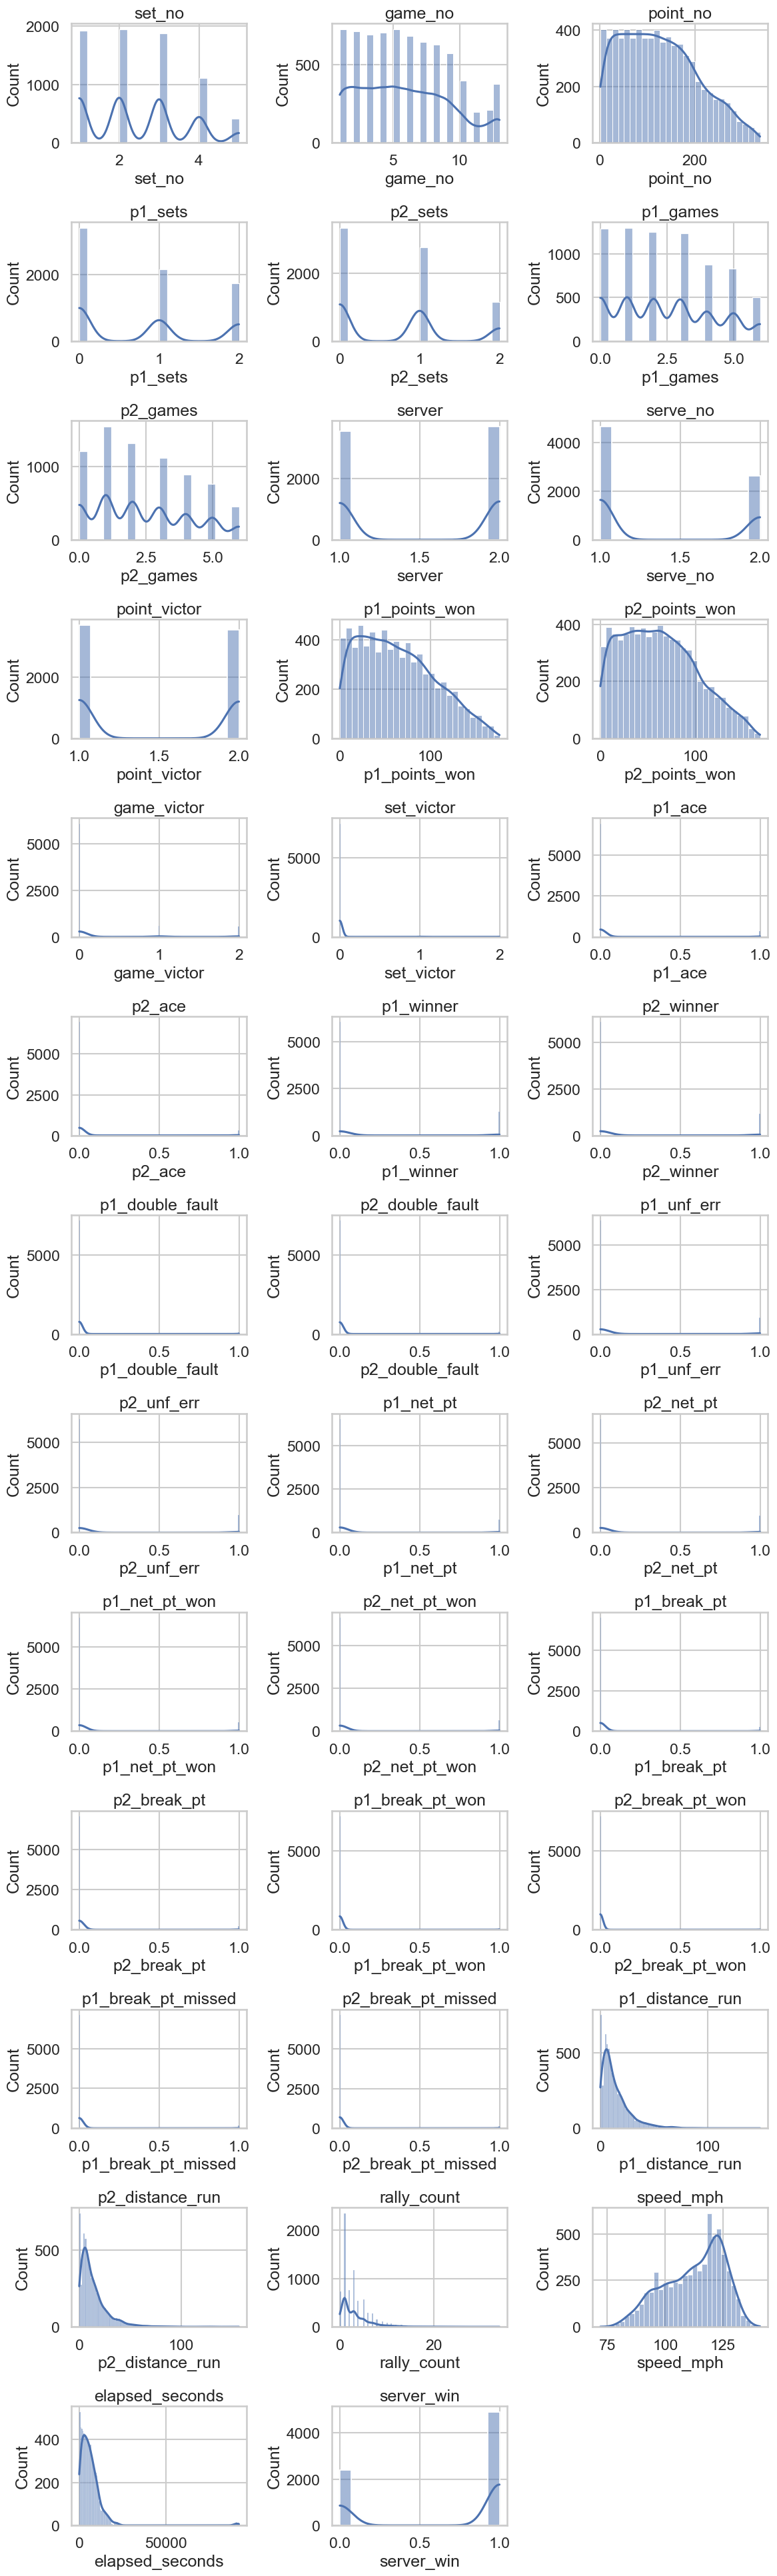

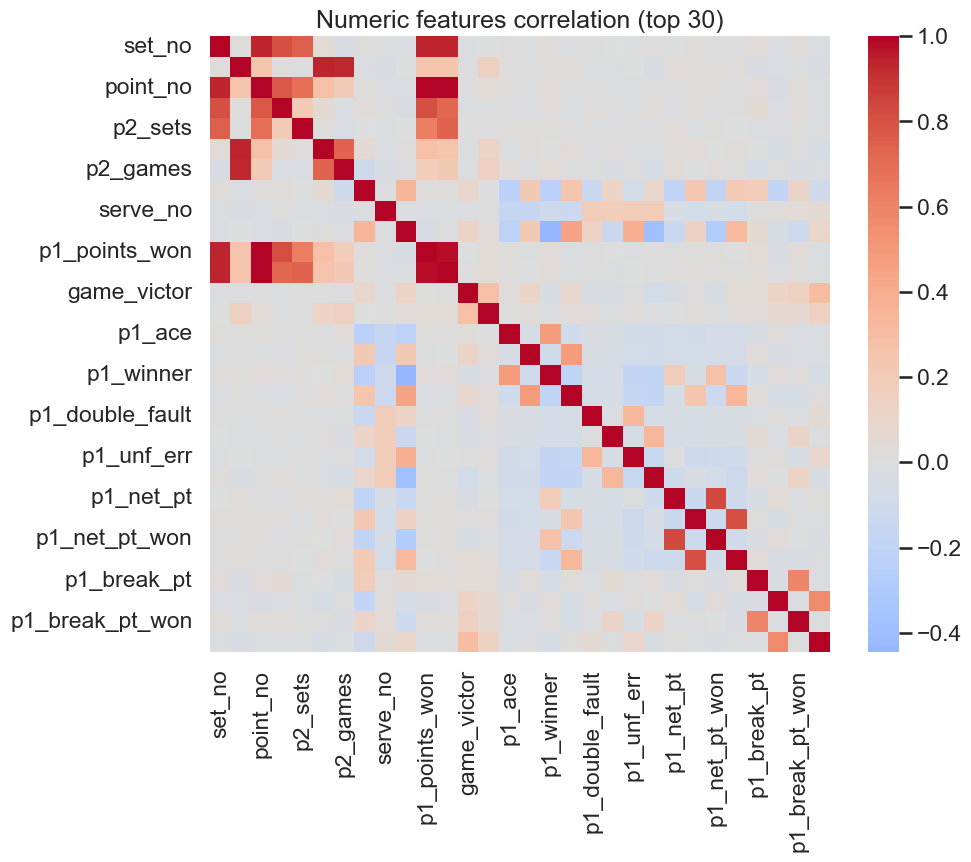

In [60]:
# 数值特征分布与相关性（自动选择数值列）
if df.empty:
    print('df 为空，请先加载数据。')
else:
    num = df.select_dtypes(include=["number"]).copy()
    if num.shape[1] == 0:
        print('没有数值列可供绘图。')
    else:
        display(num.describe().T)
        ncol = 3
        n = len(num.columns)
        nrow = (n + ncol - 1)//ncol
        fig, axes = plt.subplots(nrow, ncol, figsize=(4*ncol,3*nrow))
        axes = axes.flatten()
        for i, c in enumerate(num.columns):
            sns.histplot(num[c].dropna(), ax=axes[i], kde=True)
            axes[i].set_title(c)
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])
        plt.tight_layout()
        plt.show()

        corr_cols = num.columns[:30]
        plt.figure(figsize=(10,8))
        sns.heatmap(num[corr_cols].corr(), cmap='coolwarm', center=0)
        plt.title('Numeric features correlation (top 30)')
        plt.show()

matches: 31
points per match (min/median/max): 122 217.0 337


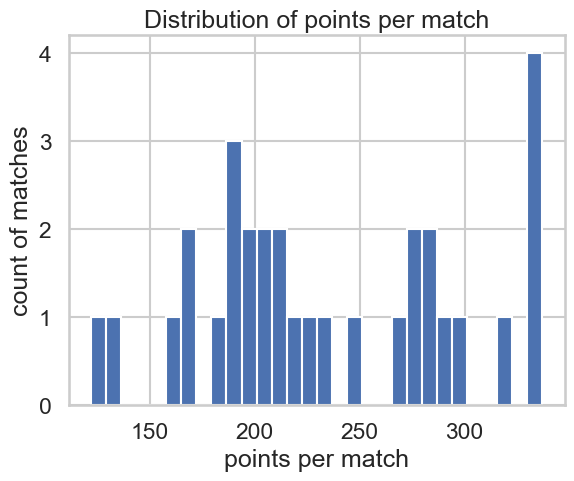

Duplicated (match_id, point_no): 0
count    31.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: missing_cnt, dtype: float64
Top matches with most missing point_no:
                     min  max  missing_cnt
match_id                                  
2023-wimbledon-1301    1  300            0
2023-wimbledon-1302    1  201            0
2023-wimbledon-1303    1  134            0
2023-wimbledon-1304    1  337            0
2023-wimbledon-1305    1  246            0
2023-wimbledon-1306    1  332            0
2023-wimbledon-1307    1  232            0
2023-wimbledon-1308    1  190            0
2023-wimbledon-1309    1  213            0
2023-wimbledon-1310    1  318            0


C:\Users\DELL\AppData\Local\Temp\ipykernel_102676\2391444428.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gaps = df.groupby("match_id").apply(check_gaps)


In [61]:
# 每场比赛的 point 数与缺口检查（来自 eda(2)）
if df.empty:
    print('df 为空，请先加载数据。')
else:
    pts_per_match = df.groupby("match_id")["point_no"].count().sort_values(ascending=False)
    print("matches:", pts_per_match.shape[0])
    print("points per match (min/median/max):", pts_per_match.min(), pts_per_match.median(), pts_per_match.max())
    plt.figure()
    plt.hist(pts_per_match.values, bins=30)
    plt.xlabel("points per match")
    plt.ylabel("count of matches")
    plt.title("Distribution of points per match")
    plt.show()

    dup = df.duplicated(subset=["match_id","point_no"]).sum()
    print("Duplicated (match_id, point_no):", dup)

    def check_gaps(g):
        s = g["point_no"].dropna().astype(int).sort_values()
        if s.empty: return pd.Series({"min": np.nan, "max": np.nan, "missing_cnt": np.nan})
        full = np.arange(s.min(), s.max()+1)
        missing = np.setdiff1d(full, s.values)
        return pd.Series({"min": s.min(), "max": s.max(), "missing_cnt": len(missing)})

    gaps = df.groupby("match_id").apply(check_gaps)
    print(gaps["missing_cnt"].describe())
    print("Top matches with most missing point_no:")
    print(gaps.sort_values("missing_cnt", ascending=False).head(10))

Monotonic non-decreasing ratio (mean): 1.0
count    31.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
dtype: float64


C:\Users\DELL\AppData\Local\Temp\ipykernel_102676\1767523494.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mono = df.groupby("match_id").apply(monotonic_ratio).dropna()


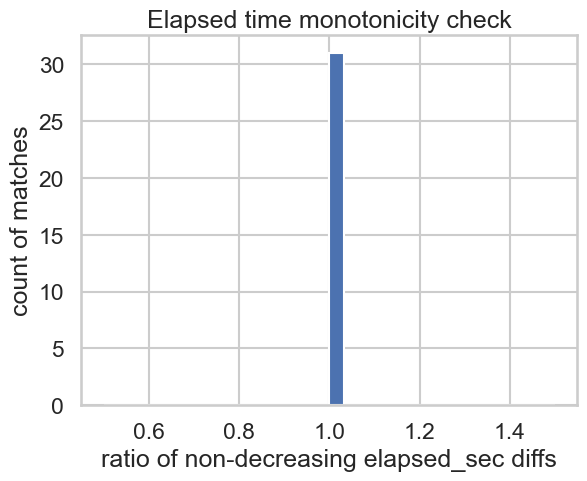

delta_t (sec) quantiles: {0.01: 15.0, 0.05: 18.0, 0.5: 34.0, 0.95: 106.0, 0.99: 147.0}


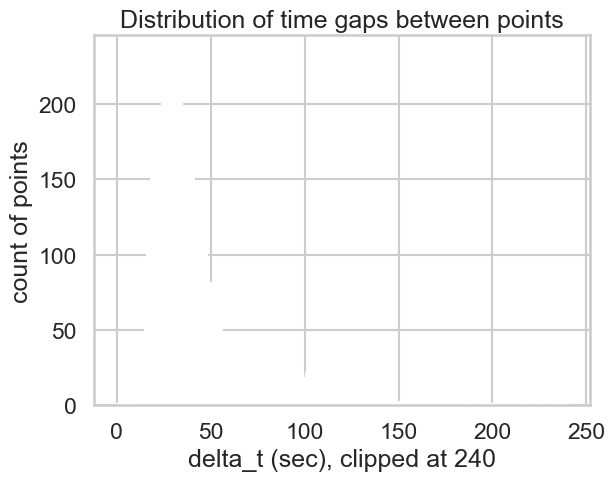

In [62]:
# elapsed_sec 单调性与点间隔检查（来自 eda(2)）
if df.empty:
    print('df 为空，请先加载数据。')
else:
    if 'elapsed_seconds' in df.columns or 'elapsed_sec' in df.columns:
        col = 'elapsed_seconds' if 'elapsed_seconds' in df.columns else 'elapsed_sec'
        def monotonic_ratio(g):
            s = g.sort_values("point_no")[col].dropna()
            if len(s) < 2: return np.nan
            return (s.diff().dropna() >= 0).mean()
        mono = df.groupby("match_id").apply(monotonic_ratio).dropna()
        print("Monotonic non-decreasing ratio (mean):", mono.mean())
        print(mono.describe())
        plt.figure()
        plt.hist(mono.values, bins=30)
        plt.xlabel("ratio of non-decreasing elapsed_sec diffs")
        plt.ylabel("count of matches")
        plt.title("Elapsed time monotonicity check")
        plt.show()

        g = df[df["match_id"].notna()].groupby("match_id", group_keys=False)
        df['delta_t'] = g[col].diff()
        dt = df['delta_t'].dropna()
        print("delta_t (sec) quantiles:", dt.quantile([0.01,0.05,0.5,0.95,0.99]).to_dict())
        plt.figure()
        plt.hist(dt.clip(upper=240).values, bins=240)
        plt.xlabel("delta_t (sec), clipped at 240")
        plt.ylabel("count of points")
        plt.title("Distribution of time gaps between points")
        plt.show()
    else:
        print('没有 elapsed 时间列供检查。')

Total runs counted: 3413
Run length (min/median/mean/max): 1 2.0 2.13419279226487 13


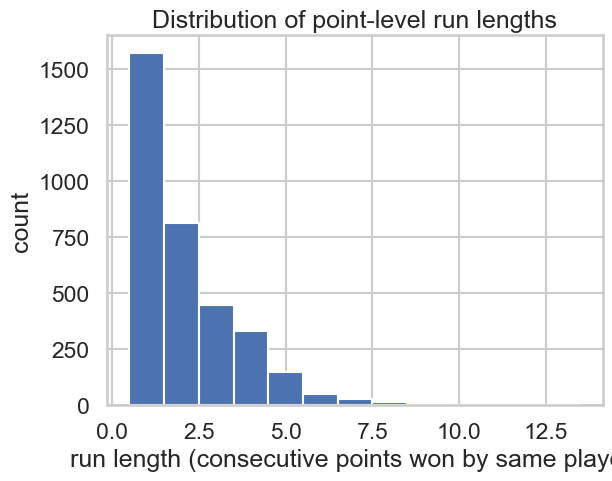

In [63]:
# Run lengths: 点级连续得分序列分布（来自 eda(2)）
if df.empty:
    print('df 为空，请先加载数据。')
else:
    def run_lengths(victor_series):
        v = victor_series.dropna().astype(int).values
        if len(v) == 0: return []
        runs = []
        cur = v[0]
        length = 1
        for x in v[1:]:
            if x == cur:
                length += 1
            else:
                runs.append(length)
                cur = x
                length = 1
        runs.append(length)
        return runs

    runs_all = []
    for mid, g in df.groupby("match_id"):
        r = run_lengths(g.sort_values("point_no")["point_victor"])
        runs_all.extend(r)
    runs_all = np.array(runs_all)
    print("Total runs counted:", len(runs_all))
    print("Run length (min/median/mean/max):", runs_all.min(), np.median(runs_all), runs_all.mean(), runs_all.max())
    plt.figure()
    plt.hist(runs_all, bins=np.arange(1, runs_all.max()+2)-0.5)
    plt.xlabel("run length (consecutive points won by same player)")
    plt.ylabel("count")
    plt.title("Distribution of point-level run lengths")
    plt.show()

matches analyzed: 31
fraction real_longest > sim 95th percentile: 0.03225806451612903


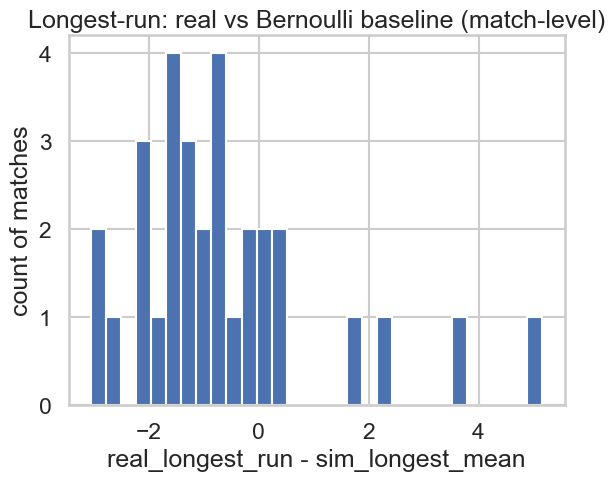

In [64]:
# 模拟检验：真实最长 run 与 Bernoulli baseline 比较（来自 eda(2)）
if df.empty:
    print('df 为空，请先加载数据。')
else:
    rng = np.random.default_rng(42)
    def longest_run_binary(x):
        if len(x) == 0: return 0
        best = 1
        cur = 1
        for i in range(1, len(x)):
            if x[i] == x[i-1]:
                cur += 1
                best = max(best, cur)
            else:
                cur = 1
        return best

    records = []
    n_sim = 200
    for mid, g in df.groupby("match_id"):
        v = g.sort_values("point_no")["point_victor"].dropna().astype(int).values
        if len(v) < 20: continue
        b = (v == 1).astype(int)
        p = b.mean()
        real_longest = longest_run_binary(b)
        sim_longest = []
        for _ in range(n_sim):
            sim = rng.binomial(1, p, size=len(b))
            sim_longest.append(longest_run_binary(sim))
        sim_longest = np.array(sim_longest)
        records.append({
            "match_id": mid,
            "n_points": len(b),
            "p1_point_win_rate": p,
            "real_longest_run": real_longest,
            "sim_longest_mean": sim_longest.mean(),
            "sim_longest_95p": np.quantile(sim_longest, 0.95),
            "real_exceeds_95p": int(real_longest > np.quantile(sim_longest, 0.95))
        })
    res = pd.DataFrame(records)
    print("matches analyzed:", len(res))
    print("fraction real_longest > sim 95th percentile:", res["real_exceeds_95p"].mean())
    plt.figure()
    plt.hist((res["real_longest_run"] - res["sim_longest_mean"]).values, bins=30)
    plt.xlabel("real_longest_run - sim_longest_mean")
    plt.ylabel("count of matches")
    plt.title("Longest-run: real vs Bernoulli baseline (match-level)")
    plt.show()

In [65]:
# break point 与 tiebreak 探索（来自 eda(2)）
if df.empty:
    print('df 为空，请先加载数据。')
else:
    if 'p1_break_pt' in df.columns and 'p2_break_pt' in df.columns:
        df['is_break_pt'] = ((df['p1_break_pt'] == 1) | (df['p2_break_pt'] == 1)).astype(int)
        bp_rate = df.groupby('is_break_pt')['server_win'].mean() if 'server_win' in df.columns else None
        print('P(server wins) by is_break_pt:', bp_rate)  
        tb_candidates = None
    if 'game_no' in df.columns:
        tb_candidates = df[df['game_no'].isin([13,14,15])].copy()
        print('Potential tiebreak-like rows (game_no in 13/14/15):', len(tb_candidates))
        print(tb_candidates[['match_id','set_no','game_no']].drop_duplicates().head(10))

    for sc in ['p1_score','p2_score']:
        if sc in df.columns:
            ad_cnt = (df[sc].astype(str) == 'AD').sum()
            print(f"{sc} == 'AD' count:", ad_cnt)

P(server wins) by is_break_pt: is_break_pt
0    0.674926
1    0.648810
Name: server_win, dtype: float64
Potential tiebreak-like rows (game_no in 13/14/15): 375
                 match_id  set_no  game_no
141   2023-wimbledon-1301       2       13
407   2023-wimbledon-1302       2       13
489   2023-wimbledon-1302       3       13
954   2023-wimbledon-1304       5       13
1325  2023-wimbledon-1306       2       13
1393  2023-wimbledon-1306       3       13
1485  2023-wimbledon-1306       4       13
1620  2023-wimbledon-1307       1       13
1690  2023-wimbledon-1307       2       13
1773  2023-wimbledon-1307       3       13
p1_score == 'AD' count: 218
p2_score == 'AD' count: 213


target match rows: 300


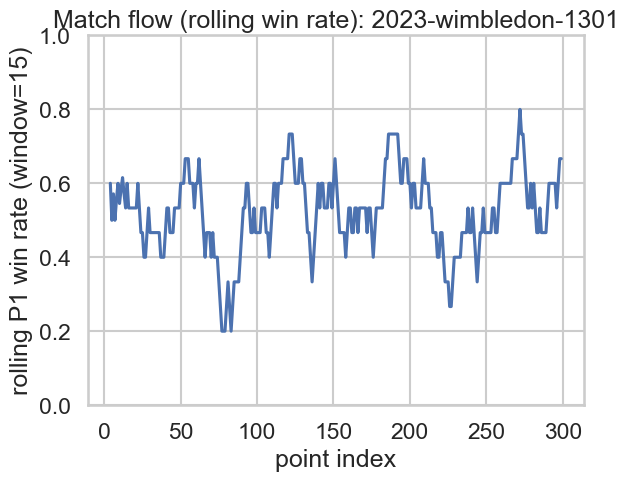

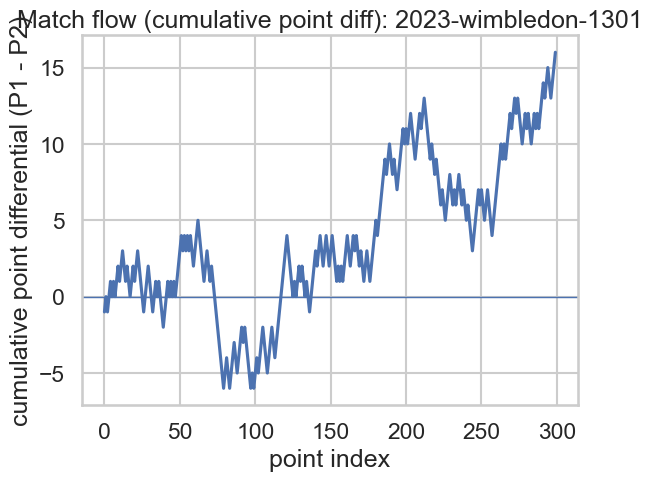

In [66]:
# 以某一场比赛为例的时序分析（示例 match_id 可替换）
if df.empty:
    print('df 为空，请先加载数据。')
else:
    target_match = df['match_id'].iat[0] if 'match_id' in df.columns else None
    if target_match is None:
        print('无可用 match_id')
    else:
        g = df[df['match_id'] == target_match].sort_values(['set_no','game_no','point_no']).copy()
        print('target match rows:', len(g))
        g['p1_win'] = np.where(g['point_victor'] == 1, 1, np.where(g['point_victor'] == 2, 0, np.nan))
        W = 15
        g['roll_p1_winrate'] = g['p1_win'].rolling(W, min_periods=max(5, W//3)).mean()
        g['cum_point_diff_p1'] = (g['p1_win'].fillna(0) - (1-g['p1_win'].fillna(0))).cumsum()
        plt.figure()
        plt.plot(g['roll_p1_winrate'].values)
        plt.ylim(0,1)
        plt.xlabel('point index')
        plt.ylabel(f'rolling P1 win rate (window={W})')
        plt.title(f'Match flow (rolling win rate): {target_match}')
        plt.show()
        plt.figure()
        plt.plot(g['cum_point_diff_p1'].values)
        plt.axhline(0, linewidth=1)
        plt.xlabel('point index')
        plt.ylabel('cumulative point differential (P1 - P2)')
        plt.title(f'Match flow (cumulative point diff): {target_match}')
        plt.show()

Correlation of rolling state at game end vs next point: 0.9219060256430542


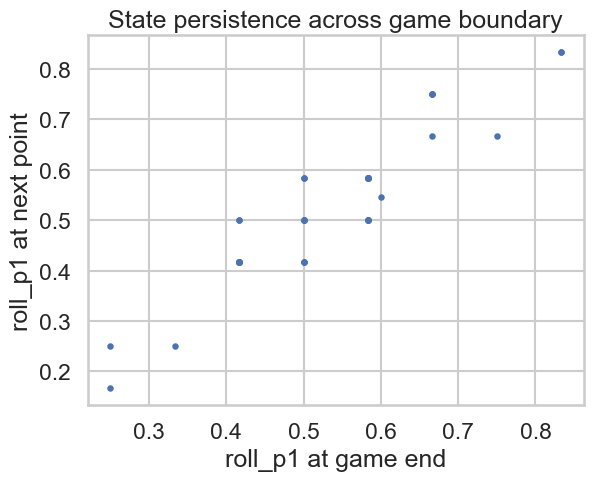

In [67]:
# State persistence across game boundary（示例）
if df.empty:
    print('df 为空，请先加载数据。')
else:
    target_match = df['match_id'].iat[0] if 'match_id' in df.columns else None
    if target_match is not None:
        g = df[df['match_id'] == target_match].sort_values(['set_no','game_no','point_no']).copy()
        g['p1_win'] = np.where(g['point_victor'] == 1, 1, np.where(g['point_victor'] == 2, 0, np.nan))
        W = 12
        g['roll_p1'] = g['p1_win'].rolling(W, min_periods=max(5, W//3)).mean()
        if 'game_victor' in g.columns:
            game_end = g[g['game_victor'].fillna(0) != 0].copy()
            idx = game_end.index.values
            next_idx = idx + 1
            next_idx = next_idx[next_idx < g.index.max()+1]
            pairs = []
            for i in idx:
                if i+1 in g.index:
                    pairs.append((g.loc[i,'roll_p1'], g.loc[i+1,'roll_p1']))
            pairs = np.array([p for p in pairs if pd.notna(p[0]) and pd.notna(p[1])])
            if len(pairs) > 0:
                corr = np.corrcoef(pairs[:,0], pairs[:,1])[0,1]
                print('Correlation of rolling state at game end vs next point:', corr)
                plt.figure()
                plt.scatter(pairs[:,0], pairs[:,1], s=10)
                plt.xlabel('roll_p1 at game end')
                plt.ylabel('roll_p1 at next point')
                plt.title('State persistence across game boundary')
                plt.show()

count    32.000000
mean      2.078156
std       0.198463
min       1.659574
25%       1.956038
50%       2.122024
75%       2.192915
max       2.547009
dtype: float64


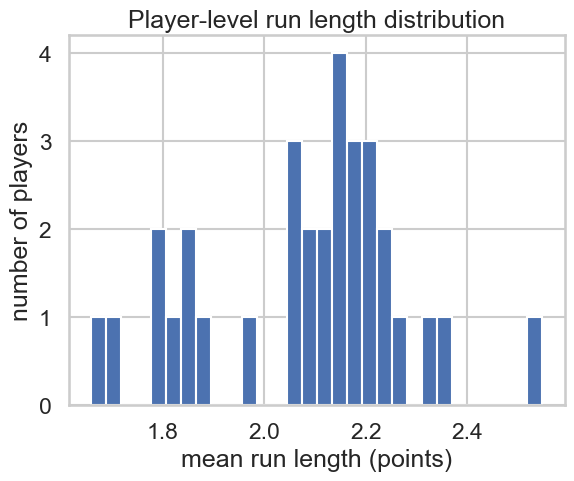

In [68]:
# Player-level run lengths（来自 eda(2)）
if df.empty:
    print('df 为空，请先加载数据。')
else:
    players = pd.concat([df[['match_id','player1']].rename(columns={'player1':'player'}), df[['match_id','player2']].rename(columns={'player2':'player'})]).drop_duplicates()
    def player_run_lengths(match_df, player_name):
        g = match_df.sort_values(['set_no','game_no','point_no'])
        wins = np.where(((g['player1'] == player_name) & (g['point_victor'] == 1)) | ((g['player2'] == player_name) & (g['point_victor'] == 2)), 1, 0)
        runs, cur = [], 0
        for w in wins:
            if w == 1: cur += 1
            else:
                if cur > 0: runs.append(cur)
                cur = 0
        if cur > 0: runs.append(cur)
        return runs
    player_run_mean = {}
    for player in players['player'].unique():
        runs = []
        for mid, g in df.groupby('match_id'):
            if player in g[['player1','player2']].values:
                runs.extend(player_run_lengths(g, player))
        if len(runs) >= 10: player_run_mean[player] = np.mean(runs)
    run_df = pd.Series(player_run_mean)
    print(run_df.describe())
    plt.figure()
    plt.hist(run_df, bins=30)
    plt.xlabel('mean run length (points)')
    plt.ylabel('number of players')
    plt.title('Player-level run length distribution')
    plt.show()

count    32.000000
mean      0.483738
std       0.038504
min       0.380597
25%       0.468750
50%       0.489029
75%       0.507866
max       0.534050
Name: win, dtype: float64


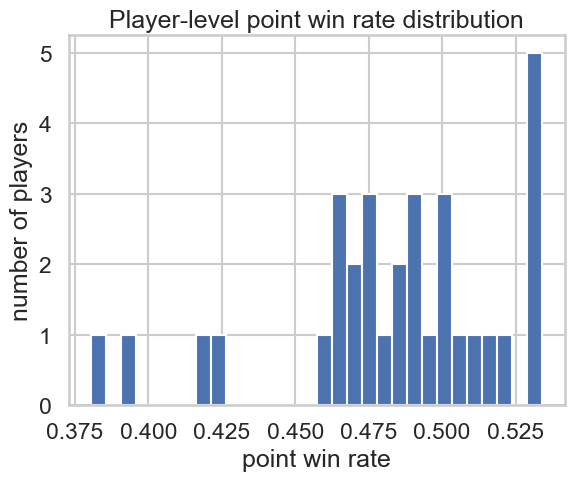

count    32.000000
mean      0.353800
std       0.086409
min       0.149904
25%       0.312691
50%       0.366549
75%       0.411812
max       0.527588
Name: serve_advantage, dtype: float64


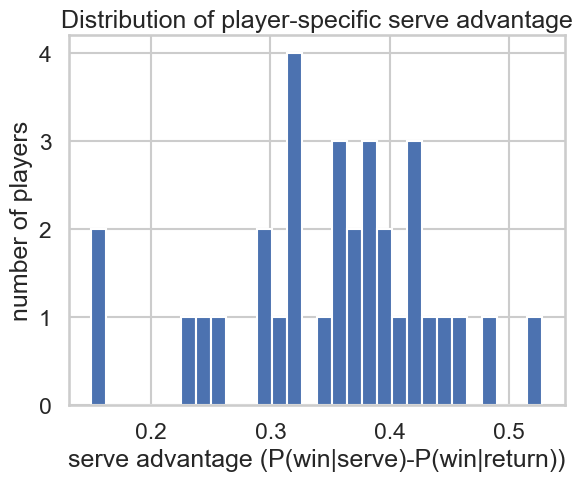

In [69]:
# 构造 player-level point outcome 与 serve advantage（来自 eda(2)）
if df.empty:
    print('df 为空，请先加载数据。')
else:
    df_long = pd.concat([
        df.assign(player=df['player1'], win=(df['point_victor']==1).astype(int), is_server=(df['server']==1).astype(int), is_break_pt=df['p1_break_pt'].fillna(0).astype(int)),
        df.assign(player=df['player2'], win=(df['point_victor']==2).astype(int), is_server=(df['server']==2).astype(int), is_break_pt=df['p2_break_pt'].fillna(0).astype(int))
    ]).reset_index(drop=True)
    player_point_wr = df_long.groupby('player')['win'].mean()
    print(player_point_wr.describe())
    plt.figure()
    plt.hist(player_point_wr, bins=30)
    plt.xlabel('point win rate')
    plt.ylabel('number of players')
    plt.title('Player-level point win rate distribution')
    plt.show()

    serve_adv = df_long.groupby(['player','is_server'])['win'].mean().unstack()
    serve_adv['serve_advantage'] = serve_adv[1] - serve_adv[0]
    serve_adv = serve_adv.dropna()
    print(serve_adv['serve_advantage'].describe())
    plt.figure()
    plt.hist(serve_adv['serve_advantage'], bins=30)
    plt.xlabel('serve advantage (P(win|serve)-P(win|return))')
    plt.ylabel('number of players')
    plt.title('Distribution of player-specific serve advantage')
    plt.show()

Momentum volatility (rolling WR std):
count    32.000000
mean      0.136726
std       0.013746
min       0.110697
25%       0.127653
50%       0.134506
75%       0.142012
max       0.175870
Name: volatility, dtype: float64


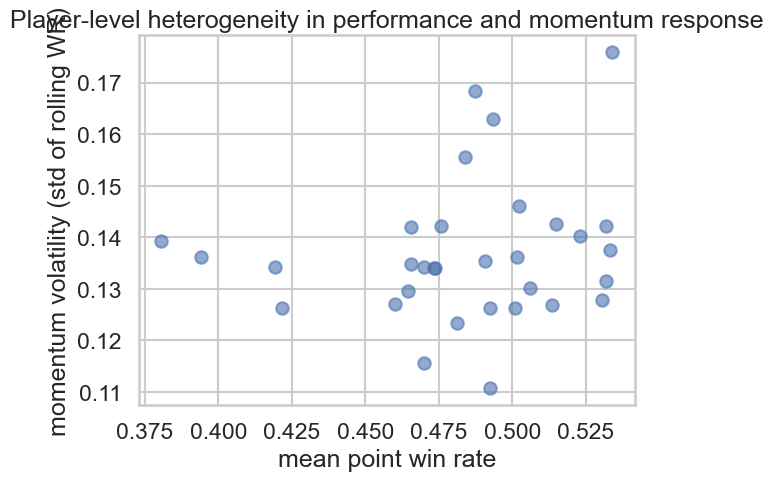

: 

In [ ]:
# player-level momentum volatility（来自 eda(2)）
if df.empty:
    print('df 为空，请先加载数据。')
else:
    df_long = df_long if 'df_long' in globals() else pd.concat([
        df.assign(player=df['player1'], win=(df['point_victor']==1).astype(int), is_server=(df['server']==1).astype(int)),
        df.assign(player=df['player2'], win=(df['point_victor']==2).astype(int), is_server=(df['server']==2).astype(int))
    ]).reset_index(drop=True)
    W = 10
    vol_data = []
    for player in df_long['player'].unique():
        player_df = df_long[df_long['player']==player].sort_values(['match_id','point_no'], ignore_index=True)
        player_df['rolling_wr'] = player_df['win'].rolling(W, min_periods=max(1, W//2)).mean()
        volatility = player_df['rolling_wr'].std()
        vol_data.append({'player': player, 'volatility': volatility})
    vol_df = pd.DataFrame(vol_data).set_index('player')['volatility']
    print('Momentum volatility (rolling WR std):')
    print(vol_df.describe())
    common = player_point_wr.to_frame('mean_wr').join(vol_df.to_frame('volatility'), how='inner')
    plt.figure()
    plt.scatter(common['mean_wr'], common['volatility'], alpha=0.6)
    plt.xlabel('mean point win rate')
    plt.ylabel('momentum volatility (std of rolling WR)')
    plt.title('Player-level heterogeneity in performance and momentum response')
    plt.show()